In [1]:
from dolfinx import fem, mesh
from mpi4py import MPI
from petsc4py.PETSc import ScalarType, ComplexType
from ufl import (TrialFunction, Measure, TestFunction, dx, ds, grad, inner, lhs, rhs)

import timeit
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import ufl

In [2]:
class BoundaryCondition():
    def __init__(self, type, marker, values, V, v, measure):
        ds = measure['Measure']
        fdim, facets, facet_tag = measure['Facets']
        
        self._type = type
        if type == "Dirichlet":
            u_D = fem.Function(V)
            u_D.interpolate(values)
            facets = facet_tag.find(marker)            
            dofs = fem.locate_dofs_topological(V, fdim, facets)
            self._bc = fem.dirichletbc(u_D, dofs)
        elif type == "Neumann":
                self._bc = inner(values, v) * ds(marker)
        elif type == "Robin":
            self._bc = values[0] * inner(u-values[1], v)* ds(marker)
        else:
            raise TypeError("Unknown boundary condition: {0:s}".format(type))
    @property
    def bc(self):
        return self._bc

    @property
    def type(self):
        return self._type

In [3]:
def generate_boundary_measure(domain, points):
    boundaries = [(1, lambda x: np.isclose(x[0], points[0])),
                  (2, lambda x: np.isclose(x[0], points[1]))]
    
    facet_indices, facet_markers = [], []
    fdim = domain.topology.dim - 1
    for (marker, locator) in boundaries:
        facets = mesh.locate_entities(domain, fdim, locator)
        facet_indices.append(facets)
        facet_markers.append(np.full_like(facets, marker))
    facet_indices = np.hstack(facet_indices).astype(np.int32)
    facet_markers = np.hstack(facet_markers).astype(np.int32)
    sorted_facets = np.argsort(facet_indices)
    facet_tag = mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

    ds = Measure("ds", domain=domain, subdomain_data=facet_tag)
    
    return {
        'Measure': ds,
        'Facets': (fdim, facets, facet_tag)
    }

In [4]:
def problem_setup(N: int,
                  points: list[float, float], 
                  fluid: str, 
                  freq: float, 
                  pressure: float):
    """
    Performs problem configuration w.r.t. given parameters
    """
    
    # Mesh and function space definition
    domain = mesh.create_interval(MPI.COMM_WORLD, N, points)
    V = fem.FunctionSpace(domain, ("CG", 1))

    u = TrialFunction(V)
    v = TestFunction(V)
    
    # Definition of density and speed functions
    ro, c, eta = fluids.loc[fluid, ['Density', 'Speed of sound', 'Viscosity']]
    omega = freq * 2 * np.pi
        
    # Construction of bilinear form and linear functional
    aa = ScalarType(ro * c**2) * inner(grad(u), grad(v)) * dx
    mm = ScalarType(ro) * inner(u, v) * dx
    cc = ScalarType(4./3 * eta) * inner(grad(u), grad(v)) * dx
    
    F = aa - omega**2 * mm + omega * 1.0j * cc
    
    measure = generate_boundary_measure(domain, points)
    
    u_D = lambda x: x[0] * 0.0
    
    boundary_conditions = [BoundaryCondition("Dirichlet", 1, u_D, V, v, measure), 
                           BoundaryCondition("Neumann", 2, ScalarType(-(pressure)), V, v, measure)]
    
    bcs = []
    for condition in boundary_conditions:
        if condition.type == "Dirichlet":
            bcs.append(condition.bc)
        else:
            F += condition.bc
    
    Left = lhs(F)
    Right = rhs(F)
    
    return {
        'Params': (N, points, fluid, omega, pressure, ro, c, eta),
        'FunctionSpace': (domain, V, u, v),
        'Problem': (Left, Right, bcs)
    }

In [5]:
fluids = pd.read_csv('../data/physical_properties.csv', sep=';', index_col='Fluid')
fluids

,Density,Speed of sound,Viscosity,Heat,Thermal conductivity,Thermal expansion
Fluid,,,,,,
Water,1000,1500,0.000894,4182.0,0.598,0.00015
Fuel oil,890,1360,2.022000,2090.0,0.150,0.00070
Oil,760,1470,0.000500,NaN,NaN,NaN
Glycerin,1260,1905,1.500000,NaN,NaN,NaN


In [6]:
config = problem_setup(N=500, 
                       points=[0.0, 0.005],
                       fluid='Glycerin',
                       freq=6.5e6,
                       pressure=1.0)

N, points, fluid, omega, pressure, density, speed, viscosity = config['Params']
domain, V, u, v = config['FunctionSpace']
Left, Right, bcs = config['Problem']

In [7]:
problem = fem.petsc.LinearProblem(Left, Right, bcs)
uh = problem.solve()

#### Exact solution for the given problem:

$$
\begin{align}
{\large u = \frac{ p \cdot sin(\frac{\omega}{c} \cdot x)) }
{ \rho \cdot c \cdot \omega \cdot cos(\frac{\omega}{c} \cdot b))} }
\end{align}
$$

In [8]:
def u_exact(x):
    return (pressure * np.sin(omega * x[0] / speed)) / \
           (density * speed * omega * np.cos(omega * points[1] / speed))

u_ex = fem.Function(V)
u_ex.interpolate(u_exact)

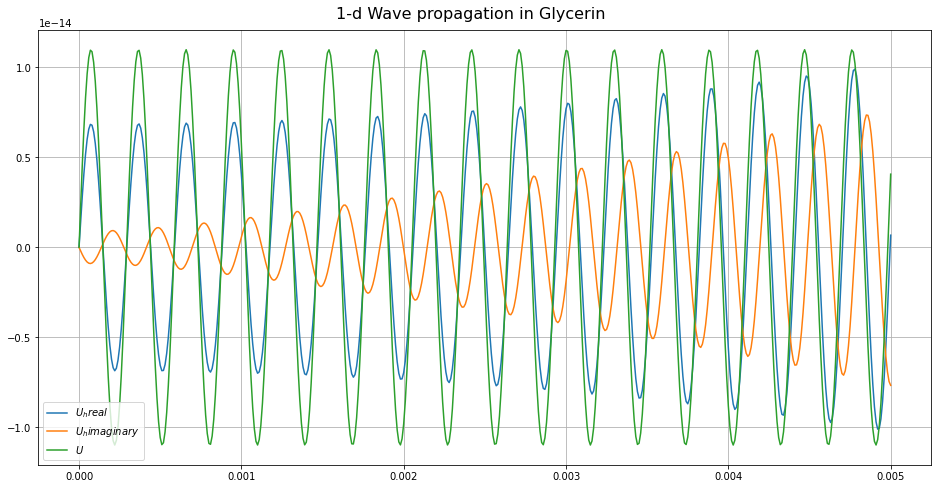

In [9]:
fig, ax = plt.subplots(figsize=(16,8))
fig.suptitle(f'1-d Wave propagation in {fluid}', y=0.92, fontsize=16)

xs1 = np.linspace(points[0], points[1], uh.vector.array.size)
xs2 = np.linspace(points[0], points[1], u_ex.vector.array.size)

ax.plot(xs1, uh.vector.array.real, label=r'$ U_h real $')
ax.plot(xs1, uh.vector.array.imag, label=r'$ U_h imaginary $')
ax.plot(xs2, u_ex.vector.array.real, label=r'$ U $')

ax.legend()
ax.grid()